<a href="https://colab.research.google.com/github/jdtoscano94/Learning-PINNs-in-Pytorch/blob/main/1_Approximate_a_function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem : **Function Approximation**

## Target Function

$$f(x)=sin(x)$$

## **Import** *Libraries*

In [149]:
 ! pip install pyDOE

In [150]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 


cpu


## **DEF** *Function*


In [151]:
def f(x):
    return torch.sin(x)

## **DEF** *Neural Network*

In [152]:
#引号中的内容：提供给非程序员或者上下文环境理解的大致解释。
#注释部分：为实际编写和阅读代码的人提供的具体技术说明。

class FCN(nn.Module):

    'Neural Network'
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
        'activation function'
        self.activation = nn.Tanh()
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        'Xavier Normal Initialization'
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            # weights from a normal distribution with 
            # Recommended gain value for tanh = 5/3?
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        a = x.float()
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z)
        a = self.linears[-1](a)
        return a

    def closure(self):
        optimizer.zero_grad()
        loss = self.loss(x_train, y_train)
        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            print(loss)
        return loss

    'Loss Functions'
    def loss(self,x,y):
      loss_val=self.loss_function(self.forward(x),y)
      return loss_val

## **DEF** *Tunning Parameters*

In [153]:
steps=20000
lr=1e-3
layers = np.array([1,50,50,20,50,50,1]) #5 hidden layers
#这个函数的功能是创建一个包含5个隐藏层的神经网络。每个隐藏层的神经元数量由layers数组指定。例如，layers数组的第一个元素1表示输入层的神经元数量为1，layers数组的第二个元素50表示第二个隐藏层的神经元数量为50。

## Generate data

生成数据集(理论公式)

In [154]:
# get the analytical solution over the full domain
min=0
max=2*np.pi
total_points=500

x = torch.linspace(min,max,total_points).view(-1,1) #prepare to NN
y = f(x)

检查数据集，画x-y图

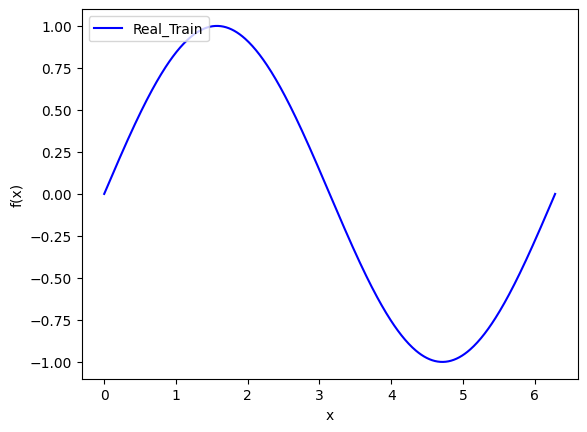

In [155]:
fig, ax1 = plt.subplots()
ax1.plot(x.detach().numpy(),y.detach().numpy(),color='blue',label='Real_Train')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('f(x)',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper left')

## Train Neural Network

### 生成训练、测试数据集

In [156]:
indices=np.arange(nx)
#np.arange(nx)在NumPy库中的含义是生成一个[0,nx-1]的整数数组，该数组用于生成数据集

train_idx,test_idx,_,_ = train_test_split(indices, indices, test_size=0.2, random_state=42)
#该函数用于将给定的indices数据集按照指定的test_size比例划分为训练集和测试集。其中，train_test_split函数是sklearn库中的一个函数，用于将数据集划分为训练集和测试集。该函数的参数包括indices（数据集）、test_size（测试集比例）、random_state（随机种子）等。该函数返回四个值，分别是训练集序号、测试集序号以及其他。

x_train=x[train_idx]
y_train=y[train_idx]
x_test=x[test_idx]
y_test=y[test_idx]

x_train=x_train.float().to(device)
y_train=y_train.float().to(device)
#将输入的x_train和y_train转换为float类型，并移动到指定的设备上。

### 生成神经网络模型

In [157]:
model = FCN(layers)
#该函数用于创建一个FCN（全卷积网络）模型，其中layers是一个包含多个卷积层的列表。FCN是一种用于图像分割的深度学习模型，它通过将卷积层与上采样层结合来实现对输入图像的像素级别的分类。该函数返回一个FCN模型对象，可以用于训练和预测。

model.to(device)
print(model)

FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=1, bias=True)
  )
)


### 选择优化算法

In [158]:
optimizer = torch.optim.Adam(model.parameters(),lr=lr,amsgrad=False)
#该函数用于创建一个Adam优化器对象，用于更新模型的参数。参数包括模型的参数、学习率和是否使用AMSGrad算法。Adam优化器是一种基于梯度下降的优化算法，可以用于训练深度学习模型。

### 核心迭代

In [159]:
torch.manual_seed(123)
#产生一个随机数
start_time = time.time()

for i in range(steps):
    optimizer.zero_grad()
    #该函数用于清除优化器中的梯度信息，在前向传播时重新计算梯度。

    yh = model(x_train)
    # model(x)表示神经网络给出的映射的拟合
    # model(x) 可以与 f(x)直接比较
    # yh表示该模型给出的映射

    loss = model.loss(x_train,y_train)
    # use mean squared error

    loss.backward()
    # loss.backward()是PyTorch中一个函数，它用于计算损失函数相对于模型参数的梯度。
    # 在深度学习训练循环的反向传播阶段通常会用到此函数。该梯度通过链式法则计算，并存储在每个模型参数的.grad属性中。

    optimizer.step()
    # optimizer优化器改进参数，在训练过程中更新模型的参数。

    if i%(steps/10)==0:
      print(loss)

tensor(0.8214, grad_fn=<MseLossBackward0>)
tensor(2.3686e-05, grad_fn=<MseLossBackward0>)
tensor(9.1647e-06, grad_fn=<MseLossBackward0>)
tensor(2.8686e-05, grad_fn=<MseLossBackward0>)
tensor(3.2467e-06, grad_fn=<MseLossBackward0>)
tensor(2.7968e-06, grad_fn=<MseLossBackward0>)
tensor(4.2584e-06, grad_fn=<MseLossBackward0>)
tensor(0.0001, grad_fn=<MseLossBackward0>)
tensor(0.0004, grad_fn=<MseLossBackward0>)
tensor(6.3597e-05, grad_fn=<MseLossBackward0>)


输出测试loss

In [162]:
print(model.loss(x_test.float().to(device),y_test.float().to(device)))
#这个函数的功能是计算模型在测试集上的损失值。具体来说，它将测试集的特征x_test和标签y_test转换为浮点数，并将其移动到指定的设备上。然后，它使用模型model来计算损失值，并将结果打印出来。

tensor(8.4081e-07, grad_fn=<MseLossBackward0>)


### 输出模型预测结果

In [163]:
yh=model(x_train)
# 输出训练集的model(x)
yh_test=model(x_test)
#yh_test=model(x_test.float().to(device))
# 输出测试集的model(x)

_,indices2=torch.sort(x_train.squeeze(1))
_,indices3=torch.sort(x_test.squeeze(1))
#对x_train和x_test进行排序，得到排序后的索引

x_train_plot=x_train[indices2]
y_train_plot=y_train[indices2]
yh_plot=yh[indices2]
x_test_plot=x_test[indices3]
y_test_plot=y_test[indices3]
yh_test_plot=yh_test[indices3]

画出测试集的函数图x-model(x)和x-f(x)

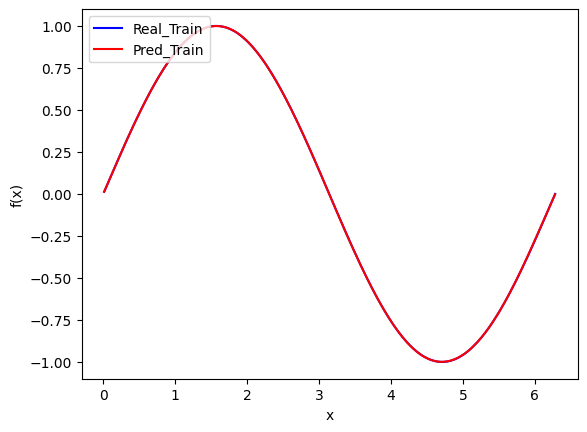

In [164]:
fig, ax1 = plt.subplots()
ax1.plot(x_train_plot.detach().cpu().numpy(),y_train_plot.detach().cpu().numpy(),color='blue',label='Real_Train')
ax1.plot(x_train_plot.detach().cpu().numpy(),yh_plot.detach().cpu().numpy(),color='red',label='Pred_Train')
#ax1.plot(x_test_plot.detach().numpy(),y_test_plot.detach().numpy(),color='green',label='Real_Test')
#ax1.plot(x_test_plot.detach().numpy(),yh_test_plot.detach().numpy(),color='orange',label='Pred_Test')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('f(x)',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper left')

画出测试集的函数图x-[f(x)-model(x)]

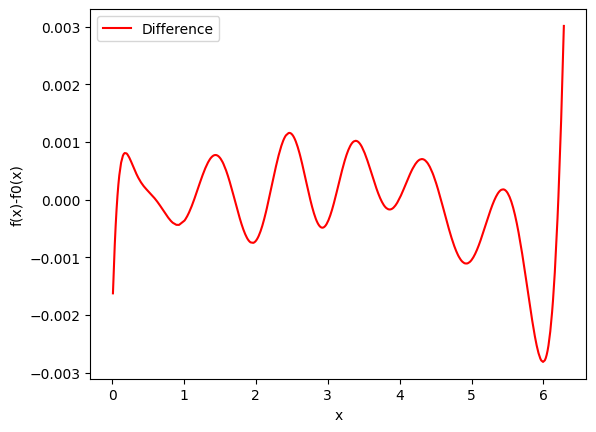

In [165]:
fig, ax1 = plt.subplots()
ax1.plot(x_train_plot.detach().cpu().numpy(),(y_train_plot-yh_plot).detach().cpu().numpy(),color='red',label='Difference')
#ax1.plot(x_test_plot.detach().numpy(),y_test_plot.detach().numpy(),color='green',label='Real_Test')
#ax1.plot(x_test_plot.detach().numpy(),yh_test_plot.detach().numpy(),color='orange',label='Pred_Test')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('f(x)-f0(x)',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper left')